<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [51]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRanker, LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [56]:
import association_metrics as am
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE, mean_absolute_error as MAE, r2_score, mean_squared_error as MSE
from scipy import stats

from sklearn.pipeline import Pipeline

In [57]:
RANDOM_STATE = 42

# Загрузка данных

In [58]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
# TRAIN = 'data\chocolate-rating\chocolate_train.csv'
# TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [59]:
train_df = pd.read_csv(TRAIN)

In [60]:
test_df = pd.read_csv(TEST)

# Обзор данных

In [61]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [62]:
train_df.shape

(1255, 9)

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [64]:
numeric_cols = train_df.select_dtypes(exclude='object').columns
cat_cols = train_df.select_dtypes(include='object').columns

In [65]:
train_df.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [66]:
train_df[cat_cols].describe()

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1254,1254
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,35,39,461,521,628,144


In [67]:
train_df['Bean Type'].describe().top

'\xa0'

In [68]:
(train_df == '\xa0').sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               628
Broad Bean Origin        55
dtype: int64

In [69]:
train_df['Specific Bean Origin'].nunique()

762

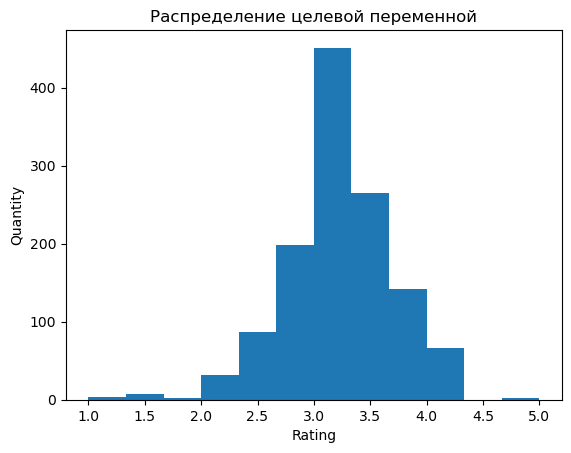

In [70]:
plt.hist(train_df['Rating'], bins=12)
plt.title('Распределение целевой переменной')
plt.xlabel('Rating')
plt.ylabel('Quantity')
plt.show();

In [71]:
test_df = train_df[['Company', 'Rating']].groupby('Rating').agg({'Company': 'count'}).sort_values('Rating')

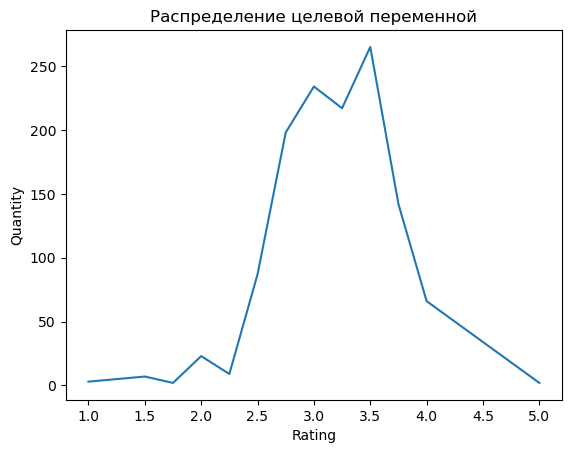

In [72]:
plt.plot(test_df)
plt.title('Распределение целевой переменной')
plt.xlabel('Rating')
plt.ylabel('Quantity')
plt.show();

Промежуточный вывод: <br>

# Обработка пропусков и выбросов

## Обработка пропусков

In [73]:
train_df = train_df.replace('\xa0', np.NaN)

In [74]:
train_df['Bean Type'] = train_df['Bean Type'].fillna('Other')
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].fillna('Other')

In [75]:
train_df[cat_cols].describe()

,Company,Specific Bean Origin,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1255,1255
unique,376,762,40,58,38,84
top,Soma,Madagascar,70%,U.S.A.,Other,Venezuela
freq,35,39,461,521,629,144


In [76]:
train_df.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

## Обработка выбросов

# Построение новых признаков

In [77]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,Other,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [78]:
arr = sorted(pd.cut(train_df['REF'], 12 * 2).unique())

In [79]:
train_df['REF'] = pd.cut(train_df['REF'], 12 * 2, labels=range(12 * 2))

In [80]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,5,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",6,2010,72%,Switzerland,3.50,Other,Venezuela
2,Dark Forest,Tanzania,19,2015,70%,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,13,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",0,2006,75%,France,3.50,Criollo,Indonesia


In [81]:
cat_cols = train_df.select_dtypes(include='object').columns

train_df[cat_cols] = train_df[cat_cols].astype('category')
train_df['Rating_cat'] = train_df['Rating'].astype('category')
cramersv = am.CramersV(train_df)
cat_cor = cramersv.fit()
cat_cor

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Rating_cat
Company,1.000000,0.771074,0.737806,0.631564,0.999651,0.616841,0.603604,0.592212
Specific Bean Origin,0.771074,1.000000,0.801503,0.772975,0.808500,0.907956,0.983377,0.758291
REF,0.737806,0.801503,1.000000,0.200624,0.327525,0.211482,0.298421,0.172818
Cocoa Percent,0.631564,0.772975,0.200624,1.000000,0.243803,0.158703,0.266313,0.238551
Company Location,0.999651,0.808500,0.327525,0.243803,1.000000,0.291616,0.383218,0.227523
Bean Type,0.616841,0.907956,0.211482,0.158703,0.291616,1.000000,0.388127,0.157569
Broad Bean Origin,0.603604,0.983377,0.298421,0.266313,0.383218,0.388127,1.000000,0.237473
Rating_cat,0.592212,0.758291,0.172818,0.238551,0.227523,0.157569,0.237473,1.000000


Заполнение пропусков в колонках 'Bean Type' и 'Broad Bean Origin' <br> на самое часто встречающееся значения соответсвующих столбцов <br> при группировке с наиболее коррелируемыми столбцами

In [82]:
train_df_clean = train_df.copy()

In [83]:
train_df_clean.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Rating_cat
0,Willie's Cacao,Rio Caribe,5,2009,72%,U.K.,3.25,Trinitario,Venezuela,3.25
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",6,2010,72%,Switzerland,3.50,Other,Venezuela,3.50
2,Dark Forest,Tanzania,19,2015,70%,U.S.A.,3.00,Other,Tanzania,3.00
3,Brasstown aka It's Chocolate,Cooproagro,13,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic,3.00
4,Pralus,"Java, Indonesie",0,2006,75%,France,3.50,Criollo,Indonesia,3.50


In [84]:
train_df_clean.nunique()

Company                 376
Specific Bean Origin    762
REF                      24
Review                   12
Cocoa Percent            40
Company Location         58
Rating                   13
Bean Type                38
Broad Bean Origin        84
Rating_cat               13
dtype: int64

In [85]:
train_df_clean['Rating'] = train_df['Rating']
train_df_clean['Cocoa Percent'] = train_df_clean['Cocoa Percent'].apply(lambda x: x.rstrip(' %')).astype(np.float32)

In [86]:
numeric_corr = train_df_clean.corr(numeric_only=True)
numeric_corr

,Review,Cocoa Percent,Rating
Review,1.000000,0.045322,0.111826
Cocoa Percent,0.045322,1.000000,-0.172411
Rating,0.111826,-0.172411,1.000000


# Отбор признаков

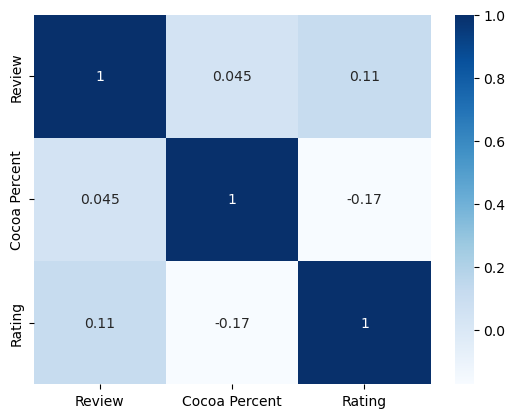

In [87]:
sns.heatmap(numeric_corr, cmap='Blues', annot=True)
plt.show();

In [88]:
cat_cor

,Company,Specific Bean Origin,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Rating_cat
Company,1.000000,0.771074,0.737806,0.631564,0.999651,0.616841,0.603604,0.592212
Specific Bean Origin,0.771074,1.000000,0.801503,0.772975,0.808500,0.907956,0.983377,0.758291
REF,0.737806,0.801503,1.000000,0.200624,0.327525,0.211482,0.298421,0.172818
Cocoa Percent,0.631564,0.772975,0.200624,1.000000,0.243803,0.158703,0.266313,0.238551
Company Location,0.999651,0.808500,0.327525,0.243803,1.000000,0.291616,0.383218,0.227523
Bean Type,0.616841,0.907956,0.211482,0.158703,0.291616,1.000000,0.388127,0.157569
Broad Bean Origin,0.603604,0.983377,0.298421,0.266313,0.383218,0.388127,1.000000,0.237473
Rating_cat,0.592212,0.758291,0.172818,0.238551,0.227523,0.157569,0.237473,1.000000


In [89]:
train_df['Company Location']

0              U.K.
1       Switzerland
2            U.S.A.
3            U.S.A.
4            France
           ...     
1250           U.K.
1251           Peru
1252         U.S.A.
1253         U.S.A.
1254         U.S.A.
Name: Company Location, Length: 1255, dtype: category
Categories (58, object): ['Amsterdam', 'Argentina', 'Australia', 'Austria', ..., 'U.S.A.', 'Venezuela', 'Vietnam', 'Wales']

In [90]:
train_df_clean = train_df_clean.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

In [91]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Rating_cat
0,Willie's Cacao,Rio Caribe,5,2009,72%,U.K.,3.25,Trinitario,Venezuela,3.25
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",6,2010,72%,Switzerland,3.50,Other,Venezuela,3.50
2,Dark Forest,Tanzania,19,2015,70%,U.S.A.,3.00,Other,Tanzania,3.00
3,Brasstown aka It's Chocolate,Cooproagro,13,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic,3.00
4,Pralus,"Java, Indonesie",0,2006,75%,France,3.50,Criollo,Indonesia,3.50


In [92]:
train_df_clean.nunique()

Company                 376
Specific Bean Origin    762
REF                      24
Review                   12
Cocoa Percent            40
Company Location         58
Rating                   13
Bean Type                38
Broad Bean Origin        84
Rating_cat               13
dtype: int64

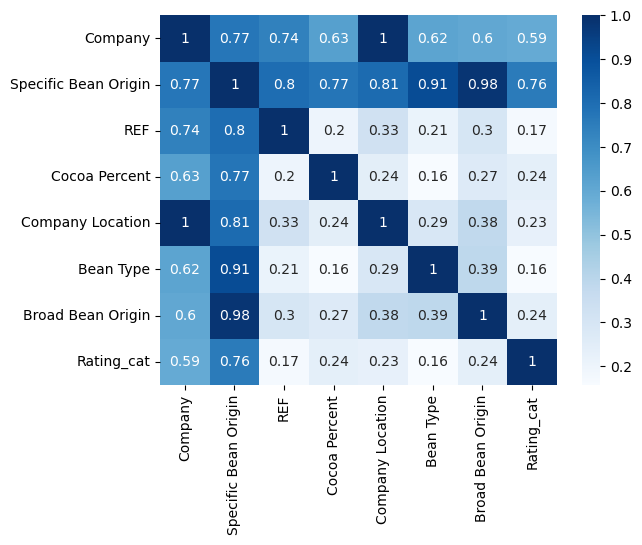

In [93]:
sns.heatmap(cat_cor, cmap='Blues', annot=True)
plt.show();

In [94]:
drop_cols = ['Specific Bean Origin', 'Review', 'Rating_cat']
train_df_clean = train_df_clean.drop(drop_cols, axis=1)
train_df_clean.head()

,Company,REF,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,5,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),6,72.0,Switzerland,3.50,Other,Venezuela
2,Dark Forest,19,70.0,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,13,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,0,75.0,France,3.50,Criollo,Indonesia


In [95]:
train_df_clean.head()

,Company,REF,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,5,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),6,72.0,Switzerland,3.50,Other,Venezuela
2,Dark Forest,19,70.0,U.S.A.,3.00,Other,Tanzania
3,Brasstown aka It's Chocolate,13,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,0,75.0,France,3.50,Criollo,Indonesia


# Построение модели

In [96]:
X = train_df_clean.drop('Rating', axis=1)
y = train_df_clean['Rating']

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [97]:
# train_df_clean.dtypes

In [98]:
# cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]

# for col in X_train.drop(X_train.columns[cat_features], axis=1):
#     print(col)
#     sns.boxplot(X_train[col])
#     plt.show()
# print('Target')
# sns.boxplot(y)
# plt.show()

In [99]:
for RANDOM_STATE in range(50, 251, 50):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype.name in ['category', 'object']]
    model = CatBoostRegressor(cat_features=cat_features)
    model.fit(X_train, y_train, verbose=False)
    print(model.score(X_train, y_train))
    pred = model.predict(X_val)

    print(r2_score(y_val, pred))

0.5226419723789194
0.18385175639840023
0.5286952227286714
0.15243049528884445
0.5990191916841598
0.1817900762697462
0.5683382033094107
0.19855142289648509
0.5863873909441418
0.17828984187435948


In [100]:
stop

NameError: name 'stop' is not defined

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1500),
        'max_depth': trial.suggest_int('depth', 2, 16),
        'verbose': 0,
        'early_stopping_rounds': 50
    }

    estimator = CatBoostRegressor(**params, cat_features=cat_features)
    estimator.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    return cross_val_score(estimator, X_train, y_train, cv=3, scoring='r2', n_jobs=5).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2025-05-10 07:01:55,149] A new study created in memory with name: no-name-1772665c-149a-4f2e-b9ca-8d7f6e5f6cdc
[W 2025-05-10 07:01:57,455] Trial 0 failed with parameters: {'learning_rate': 0.060249377018773684, 'n_estimators': 242, 'depth': 14} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\kuche\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kuche\AppData\Local\Temp\ipykernel_4752\3464648288.py", line 11, in objective
    estimator.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
  File "c:\Users\kuche\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
hyper_param_model = CatBoostRegressor(**study.best_params, cat_features=cat_features, verbose=False)
hyper_param_model.fit(X_train, y_train)
new_pred = hyper_param_model.predict(X_val)
r2_score(y_val, new_pred)
# 0.22796892470738905

0.23137562797778854

In [ ]:
cb_train_pred = hyper_param_model.predict(X_train)
r2_score(y_train, cb_train_pred)
# 0.3794773884333069

0.5151352876833575

In [ ]:
hyper_param_model.score(X_train, y_train)
# 0.3794773884333069

0.5151352876833575

In [ ]:
cat_cols = X_train.select_dtypes(include='category').columns

X_train[cat_cols] = X_train[cat_cols].astype('object')
X_val[cat_cols] = X_val[cat_cols].astype('object')

In [ ]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('scaler_', MinMaxScaler()),
    ('model_', LinearRegression())
    ])

p9 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestRegressor(n_jobs=-1))
    ])

for i, p in enumerate([p1,p2,p3,p4,p5,p6,p7,p8,p9]):
    p.fit(X_train, y_train)
    pred = p.predict(X_val)
    print(i + 1, r2_score(y_val, pred))

1 0.09229608170077042
2 0.06714478553830172
3 0.1049899850181012
4 0.06714478553830172
5 0.09229608170077086
6 0.10498998501810097
7 0.12514354868988875
8 0.12514354868988886
9 0.059268608738298756


In [ ]:
lr_pred = p8.predict(X_val)

final_pred = 0.8 * new_pred + 0.2 * lr_pred

r2_score(y_val, final_pred)

0.22828068581125704

In [ ]:
test_df = pd.read_csv(TEST)

In [ ]:
test_df = test_df.replace('\xa0', np.NaN)

In [ ]:
test_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Bean Type               259
Broad Bean Origin        18
dtype: int64

In [ ]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,NaN,NaN
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             281 non-null    object
 7   Broad Bean Origin     522 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [ ]:
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: x.rstrip(' %')).astype(np.float32)

In [ ]:
test_df_clean = test_df.copy()
test_df_clean['Bean Type'] = test_df_clean['Bean Type'].fillna('Other')
test_df_clean['Broad Bean Origin'] = test_df_clean['Broad Bean Origin'].fillna('Other')

In [ ]:
test_df.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Bean Type               259
Broad Bean Origin        18
dtype: int64

In [ ]:
def REF_transform(x):
    for n, inerval in enumerate(arr, 1):
        if x in inerval:
            return n

In [ ]:
test_df_clean['REF'] = test_df_clean['REF'].apply(REF_transform)

In [ ]:
test_df_clean.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",20,2015,70.0,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,4,2009,72.0,Spain,Other,Other
2,Brazen,Maya Mountain,19,2015,80.0,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,6,2009,67.0,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",8,2010,82.0,U.S.A.,Matina,Costa Rica


In [ ]:
test_df_clean.nunique()

Company                 244
Specific Bean Origin    385
REF                      24
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                20
Broad Bean Origin        60
dtype: int64

In [ ]:
drop_cols = ['Specific Bean Origin', 'Review']
test_df_clean = test_df_clean.drop(drop_cols, axis=1)
test_df_clean.head()

,Company,REF,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,20,70.0,U.S.A.,Trinitario,Trinidad
1,Blanxart,4,72.0,Spain,Other,Other
2,Brazen,19,80.0,U.S.A.,Trinitario,Belize
3,Patric,6,67.0,U.S.A.,Trinitario,Madagascar
4,Potomac,8,82.0,U.S.A.,Matina,Costa Rica


In [ ]:
test_df_clean = test_df_clean.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

In [ ]:
y_pred = hyper_param_model.predict(test_df_clean)
lr_pred = p8.predict(test_df_clean)
y_pred_2 = 0.8* y_pred + 0.2 * lr_pred

In [ ]:
cleaned_test_df = pd.DataFrame()
cleaned_test_df['id'] = np.arange(len(test_df))
cleaned_test_df['Rating'] = y_pred_2

cleaned_test_df[['id','Rating']].to_csv("choko_submission.csv", index=False)